# <b> <font color = #03396c> JPMC TEAM #1</b></font>
## <b>Price Prediction using XGBOOST</b>
In this notebook, we will create dataframes of the S&P500 stocks' price percentage change over a week for the year of 2022. We will then use the clusters we found from our cluster exploration to prove our hypothesis that: 'Using clusters as opposed to all the stocks in the XGBoost model will, in turn, produce more accruate price predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import yfinance as yf

In [2]:
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S%26P_500_component_stocks')
table_symbol = data[0]
table_industry = data[0]['GICS Sector']

#these 2 lists are in order with one another
symbols = list(table_symbol.Symbol.values)
industries = list(table_industry.values) ##Industry Sector

remove = []

symbols_to_remove = ['BF.B', 'BRK.B', 'KVUE', 'VLTO','SPY']

for i, symbol in enumerate(symbols):
    if symbol in symbols_to_remove:
        remove.append(i)

for i in remove:
    symbols.remove(symbols[i])
    industries.remove(industries[i])

print(len(symbols))

symbol_industry = dict(zip(symbols,industries))
print(len(symbol_industry))

499
499


In [3]:
tickers = yf.Tickers('AAPL')

APPLdf = tickers.tickers['AAPL'].history(period="5d", start="2022-01-01", end="2022-12-31")
APPLdf.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-03 00:00:00-05:00,175.821100,180.814055,175.702461,179.953873,104487900,0.0,0.0
2022-01-04 00:00:00-05:00,180.566891,180.873387,177.096533,177.669983,99310400,0.0,0.0
2022-01-05 00:00:00-05:00,177.581022,178.134693,172.667164,172.944000,94537600,0.0,0.0
2022-01-06 00:00:00-05:00,170.749066,173.319700,169.701043,170.056976,96904000,0.0,0.0
2022-01-07 00:00:00-05:00,170.936904,172.172783,169.097916,170.225037,86709100,0.0,0.0
2022-01-10 00:00:00-05:00,167.169974,170.551338,166.270251,170.244843,106765600,0.0,0.0
2022-01-11 00:00:00-05:00,170.373387,173.201065,168.890332,173.102203,76138300,0.0,0.0
2022-01-12 00:00:00-05:00,174.130420,175.178443,172.845118,173.547089,74805200,0.0,0.0
2022-01-13 00:00:00-05:00,173.794284,174.624791,169.849352,170.244843,84505800,0.0,0.0


In [4]:
drop_cols = ['Open', 'Low', 'High','Volume', 'Dividends', 'Stock Splits']
APPLdf = APPLdf.drop(columns=drop_cols, axis = 1)
APPLdf.index = APPLdf.index.astype(str).str.split(' ').str[0]
APPLdf

,Close
Date,
2022-01-03,179.953873
2022-01-04,177.669983
2022-01-05,172.944000
2022-01-06,170.056976
2022-01-07,170.225037
...,...
2022-12-23,131.127075
2022-12-27,129.307236
2022-12-28,125.339409


In [5]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=1, cols=1, subplot_titles=('Price of APPL for 2022',))

# Add trace for Close price
fig.add_trace(go.Scatter(x=APPLdf.index, y=APPLdf['Close'], name='Close Price'), row=1, col=1)

# Get unique months in the DataFrame
unique_months = pd.to_datetime(APPLdf.index).to_period('M').unique()

# Update x-axis layout to show ticks for each month
fig.update_xaxes(
    tickmode='array',
    tickvals=unique_months.to_timestamp(),  # Convert to timestamp for plotting
    ticktext=unique_months.strftime('%b'),  # Displaying abbreviated month names
)
# Show figure
fig.show()

In [6]:
holidays = ["2022-01-17","2022-02-21","2022-04-15", "2022-05-30", "2022-06-20", "2022-07-4", "2022-09-5", "2022-11-24","2022-12-26"]
len(holidays)

9

In [7]:
holiday_df = pd.DataFrame(index=holidays)
holiday_df['Date'] = holiday_df.index

# Add another column 'Close' with NaN values
holiday_df['Close'] = float('nan')

# Set the 'Date' column as the index
holiday_df.set_index('Date', inplace=True)

# Print the resulting DataFrame
holiday_df.dtypes

Close    float64
dtype: object

In [8]:
APPLdf.loc["2022-11-25"]

Close    147.286743
Name: 2022-11-25, dtype: float64

In [9]:
# Assuming APPLdf and holiday_df are DataFrames

# Concatenate the original DataFrame with the holiday DataFrame
frames = [APPLdf, holiday_df]
result_df = pd.concat(frames)

# Convert the index to a consistent data type (e.g., Timestamp)
result_df.index = pd.to_datetime(result_df.index)

# Sort the index to maintain order
result_df = result_df.sort_index()

# Print the resulting DataFrame
APPL1 = result_df
APPL1


,Close
Date,
2022-01-03,179.953873
2022-01-04,177.669983
2022-01-05,172.944000
2022-01-06,170.056976
2022-01-07,170.225037
...,...
2022-12-26,NaN
2022-12-27,129.307236
2022-12-28,125.339409


In [10]:
# Convert index to datetime if it's in string format
APPL1.index = pd.to_datetime(APPL1.index)

# Create a new DataFrame with the desired structure
new_df = pd.DataFrame(index=[f'APPL Week {week}' for week in range(1, 53)],
                      columns=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'])

# Iterate through rows of the original DataFrame and fill the new DataFrame
for i, row in APPL1.iterrows():
    week = i.week
    day = i.dayofweek
    
    # If there are rows for the current week and day, set the mean close price
    if not pd.isna(row['Close']):
        new_df.at[f'APPL Week {week}', f'Day {day + 1}'] = row['Close']

# Display the new DataFrame
APPL = new_df
nan_rows = new_df[new_df.isna().any(axis=1)]
nan_rows

,Day 1,Day 2,Day 3,Day 4,Day 5
APPL Week 3,NaN,167.881836,164.352142,162.651581,160.575317
APPL Week 8,NaN,162.670746,158.463379,161.106598,163.195404
APPL Week 15,164.086349,165.977203,168.689713,163.630966,NaN
APPL Week 22,NaN,147.562592,147.433701,149.912262,144.132278
APPL Week 25,NaN,134.703888,134.18837,137.083313,140.444199
APPL Week 27,NaN,140.345078,141.693375,145.093948,145.77803
APPL Week 36,NaN,153.41655,154.836258,153.347061,156.236084
APPL Week 47,147.187286,149.345215,150.230301,NaN,147.286743
APPL Week 52,NaN,129.307236,125.339409,128.889572,129.207779


In [11]:
# Convert index to datetime if it's in string format
APPL1.index = pd.to_datetime(APPL1.index)

# Create a new DataFrame with the desired structure
new_df = pd.DataFrame(index=[f'APPL Week {week}' for week in range(1, 53)],
                      columns=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'])

# Iterate through rows of the original DataFrame and fill the new DataFrame
for i, row in APPL1.iterrows():
    week = i.week
    day = i.dayofweek
    
    # If there are rows for the current week and day, set the mean close price
    if not pd.isna(row['Close']):
        new_df.at[f'APPL Week {week}', f'Day {day + 1}'] = row['Close']

# Drop rows with NaN values
new_df = new_df.dropna()

# Display the new DataFrame
APPL = new_df
APPL = APPL.drop(['APPL Week 1'], axis=0)
APPL


,Day 1,Day 2,Day 3,Day 4,Day 5
APPL Week 2,170.244843,173.102203,173.547089,170.244843,171.114899
APPL Week 4,159.794235,157.975037,157.886047,157.421341,168.405838
APPL Week 5,172.805542,172.637512,173.853592,170.946793,170.659744
APPL Week 6,169.937057,173.075256,174.510681,170.392441,166.947357
APPL Week 7,167.184952,171.05571,170.81813,167.184952,165.620804
APPL Week 9,163.462677,161.561951,164.888229,164.561539,161.532257
APPL Week 10,157.701111,155.859772,161.314468,156.928955,153.176987
APPL Week 11,149.108231,153.533356,157.98819,159.007858,162.334152
APPL Week 12,163.720078,167.125549,168.501602,172.322861,172.966354
APPL Week 13,173.837509,177.163788,175.985733,172.857468,172.560455


In [12]:
APPLPCT1 = APPL1.pct_change()
APPLPCT1

/var/folders/bq/q6bbfq_s68l_m1x6yxgvqnt80000gn/T/ipykernel_31244/1966763988.py:1: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.



,Close
Date,
2022-01-03,NaN
2022-01-04,-0.012692
2022-01-05,-0.026600
2022-01-06,-0.016693
2022-01-07,0.000988
...,...
2022-12-26,0.000000
2022-12-27,-0.013878
2022-12-28,-0.030685


In [13]:
# Convert index to datetime if it's in string format
APPLPCT1.index = pd.to_datetime(APPL1.index)

# Create a new DataFrame with the desired structure
new_df = pd.DataFrame(index=[f'APPL PC Week {week}' for week in range(1, 53)],
                      columns=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'])

# Iterate through rows of the original DataFrame and fill the new DataFrame
for i, row in APPLPCT1.iterrows():
    week = i.week
    day = i.dayofweek
    
    # If there are rows for the current week and day, set the mean close price
    if not pd.isna(row['Close']):
        new_df.at[f'APPL PC Week {week}', f'Day {day + 1}'] = row['Close']

new_df.replace(0, pd.NA, inplace=True)

# Drop rows with NaN values
new_df = new_df.dropna()

# Display the new DataFrame
APPLPCT = new_df
APPLPCT.shape

(41, 5)

In [14]:
tickers = yf.Tickers('MMM')

MMMdf = tickers.tickers['MMM'].history(period="5d", start="2022-01-01", end="2022-12-31")
drop_cols = ['Open', 'Low', 'High','Volume', 'Dividends', 'Stock Splits']
MMMdf = MMMdf.drop(columns=drop_cols, axis = 1)
MMMdf.index = MMMdf.index.astype(str).str.split(' ').str[0]
frames = [MMMdf, holiday_df]
result_df = pd.concat(frames)

# Convert the index to a consistent data type (e.g., Timestamp)
#result_df.index = pd.to_datetime(result_df.index)

# Sort the index to maintain order
result_df = result_df.sort_index()

# Print the resulting DataFrame
MMM1 = result_df
MMM1
pct = MMM1.ffill().pct_change()
pct

,Close
Date,
2022-01-03,NaN
2022-01-04,0.014009
2022-01-05,-0.004106
2022-01-06,-0.008301
2022-01-07,0.010955
...,...
2022-12-26,0.000000
2022-12-27,0.000666
2022-12-28,-0.016054


In [15]:
pct = MMM1.ffill().pct_change()
pct

,Close
Date,
2022-01-03,NaN
2022-01-04,0.014009
2022-01-05,-0.004106
2022-01-06,-0.008301
2022-01-07,0.010955
...,...
2022-12-26,0.000000
2022-12-27,0.000666
2022-12-28,-0.016054


In [16]:
# Get the list of S&P 500 stocks
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = sp500['Symbol'].tolist()

# Remove specified tickers from the list of S&P 500 stock
# Function to fetch data and create price percentage DataFrame
def get_price_percentage_df(ticker):
    try:
        stock_data = yf.download(ticker, start="2022-01-01", end="2022-12-31")
        drop_cols = ['Open', 'Low', 'High', 'Adj Close', 'Volume']
        stock_data = stock_data.drop(columns=drop_cols, axis=1)
        stock_data.index = stock_data.index.astype(str).str.split(' ').str[0]
        result_df = stock_data.ffill().pct_change()
        result_df.columns = [f"{ticker}" for col in result_df.columns]
        return result_df
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

# <b> Here create the cluster dfs

In [17]:

# Fetch data for each ticker and create price percentage DataFrame
pct_dfs = []
for ticker in sp500_tickers:
        pct_df = get_price_percentage_df(ticker)
        if not pct_df.empty:
            pct_dfs.append(pct_df)

# Concatenate the DataFrames
sp500_pct_df = pd.concat(pct_dfs, axis=1)

# Display the resulting DataFrame
sp500_pct_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2022-12-31)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1641013200, endDate = 1672462800")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1641013200, endDate = 1672462800")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,0.014009,0.016633,-0.023518,-0.001920,-0.007146,0.018559,-0.018374,0.004672,0.002871,0.032778,...,0.013160,0.020129,-0.003190,0.006329,0.010608,0.005347,0.006337,0.010145,0.028487,-0.038072
2022-01-05,-0.004106,-0.016714,-0.004493,0.005253,-0.017611,-0.007809,-0.071426,-0.008525,-0.045808,-0.001662,...,-0.006955,-0.023287,-0.037033,0.009800,-0.013629,-0.012677,-0.050068,-0.003297,0.002270,-0.038024
2022-01-06,-0.008301,0.006703,-0.000148,-0.004710,-0.048290,0.008891,-0.000603,-0.006871,-0.003858,0.018475,...,-0.011265,0.003502,0.004629,-0.007822,-0.001373,0.010331,-0.005410,-0.008307,0.041075,0.003971
2022-01-07,0.010955,-0.011296,0.003108,-0.002588,-0.019180,0.008523,-0.006652,-0.010564,-0.006024,0.015852,...,-0.011863,-0.008802,-0.001063,0.008759,-0.007992,-0.011466,-0.043771,-0.006050,0.016681,-0.029114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.011925,0.011915,0.001389,-0.001041,0.005023,0.012087,0.005735,0.007443,0.013070,0.011846,...,0.008626,0.006644,-0.006401,0.012852,-0.000728,0.000621,0.002869,-0.000789,0.003521,0.005033
2022-12-27,0.000666,0.013532,0.003605,-0.000674,-0.002931,0.013633,-0.009928,0.000374,0.004881,0.006829,...,0.000777,0.000407,0.044723,0.009023,0.009022,0.007758,0.011200,0.004657,0.008050,-0.003156
2022-12-28,-0.016054,-0.015606,-0.006816,-0.004663,-0.008255,-0.023877,-0.020174,-0.013193,-0.017349,-0.010659,...,-0.011612,-0.014629,-0.050279,-0.013972,-0.016077,-0.004542,-0.016574,-0.010135,-0.017813,-0.010117


In [18]:
df_labels = pd.read_csv('df_labels.csv')
df_labels = df_labels.loc[:496]
comp = list(df_labels['Company'])
# if the company in sp500pct is not in comp, drop it
for i in sp500_pct_df.columns:
    if i not in comp:
        sp500_pct_df.drop(i, axis=1, inplace=True)
sp500_pct_df


,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,0.014009,0.016633,-0.023518,-0.001920,-0.007146,0.018559,-0.018374,0.004672,0.002871,0.032778,...,0.013160,0.020129,-0.003190,0.006329,0.010608,0.005347,0.006337,0.010145,0.028487,-0.038072
2022-01-05,-0.004106,-0.016714,-0.004493,0.005253,-0.017611,-0.007809,-0.071426,-0.008525,-0.045808,-0.001662,...,-0.006955,-0.023287,-0.037033,0.009800,-0.013629,-0.012677,-0.050068,-0.003297,0.002270,-0.038024
2022-01-06,-0.008301,0.006703,-0.000148,-0.004710,-0.048290,0.008891,-0.000603,-0.006871,-0.003858,0.018475,...,-0.011265,0.003502,0.004629,-0.007822,-0.001373,0.010331,-0.005410,-0.008307,0.041075,0.003971
2022-01-07,0.010955,-0.011296,0.003108,-0.002588,-0.019180,0.008523,-0.006652,-0.010564,-0.006024,0.015852,...,-0.011863,-0.008802,-0.001063,0.008759,-0.007992,-0.011466,-0.043771,-0.006050,0.016681,-0.029114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.011925,0.011915,0.001389,-0.001041,0.005023,0.012087,0.005735,0.007443,0.013070,0.011846,...,0.008626,0.006644,-0.006401,0.012852,-0.000728,0.000621,0.002869,-0.000789,0.003521,0.005033
2022-12-27,0.000666,0.013532,0.003605,-0.000674,-0.002931,0.013633,-0.009928,0.000374,0.004881,0.006829,...,0.000777,0.000407,0.044723,0.009023,0.009022,0.007758,0.011200,0.004657,0.008050,-0.003156
2022-12-28,-0.016054,-0.015606,-0.006816,-0.004663,-0.008255,-0.023877,-0.020174,-0.013193,-0.017349,-0.010659,...,-0.011612,-0.014629,-0.050279,-0.013972,-0.016077,-0.004542,-0.016574,-0.010135,-0.017813,-0.010117


In [19]:
holidays = ["2022-01-17","2022-02-21","2022-04-15", "2022-05-30", "2022-06-20", "2022-07-4", "2022-09-5", "2022-11-24","2022-12-26"]
columns = sp500_pct_df.columns

# Create holiday_df| with NaN values for each date and columns matching sp500_pct_df
holiday_df = pd.DataFrame(index=holidays, columns=columns)
holiday_df['Date'] = holiday_df.index

# Set the 'Date' column as the index
holiday_df.set_index('Date', inplace=True)
holiday_df.shape

(9, 497)

In [20]:
result_df = pd.concat([sp500_pct_df, holiday_df], axis=0)
# Sort the DataFrame by index to maintain order
result_df = result_df.sort_index()
sp500_pct_df = result_df

/var/folders/bq/q6bbfq_s68l_m1x6yxgvqnt80000gn/T/ipykernel_31244/4063037227.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [21]:
sp500_pct_df.T

Date,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-10,2022-01-11,2022-01-12,2022-01-13,2022-01-14,...,2022-12-19,2022-12-20,2022-12-21,2022-12-22,2022-12-23,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30
MMM,NaN,0.014009,-0.004106,-0.008301,0.010955,-0.014115,0.008850,0.002458,0.008918,-0.012595,...,0.003616,-0.010808,0.021935,-0.015147,-0.011925,NaN,0.000666,-0.016054,0.019275,-0.005391
AOS,NaN,0.016633,-0.016714,0.006703,-0.011296,-0.003127,0.009772,0.003345,-0.012384,-0.028575,...,0.000178,0.004995,0.015974,-0.017645,0.011915,NaN,0.013532,-0.015606,0.015677,-0.007284
ABT,NaN,-0.023518,-0.004493,-0.000148,0.003108,-0.002213,0.003253,-0.014591,-0.030437,-0.011492,...,-0.002993,-0.000938,0.015494,-0.001017,0.001389,NaN,0.003605,-0.006816,0.022999,-0.004714
ABBV,NaN,-0.001920,0.005253,-0.004710,-0.002588,0.011195,0.004253,0.002336,-0.027460,0.017600,...,0.006294,-0.005635,0.010151,0.006535,-0.001041,NaN,-0.000674,-0.004663,0.002034,-0.005844
ACN,NaN,-0.007146,-0.017611,-0.048290,-0.019180,0.006069,0.005657,0.005545,-0.041942,-0.022166,...,-0.034332,0.025450,0.026804,-0.015469,0.005023,NaN,-0.002931,-0.008255,0.019991,-0.005738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,NaN,0.005347,-0.012677,0.010331,-0.011466,-0.013964,-0.020980,-0.011557,-0.002633,-0.013586,...,-0.007652,0.001636,0.001478,0.000311,0.000621,NaN,0.007758,-0.004542,0.005259,-0.014693
ZBRA,NaN,0.006337,-0.050068,-0.005410,-0.043771,0.008571,0.005902,-0.000241,-0.023475,0.004184,...,-0.020930,0.014115,0.014930,-0.013275,0.002869,NaN,0.011200,-0.016574,0.043307,-0.004349
ZBH,NaN,0.010145,-0.003297,-0.008307,-0.006050,-0.009754,0.011663,-0.021810,0.019828,-0.005388,...,-0.004937,0.003761,0.013155,-0.002282,-0.000789,NaN,0.004657,-0.010135,0.014604,-0.002582
ZION,NaN,0.028487,0.002270,0.041075,0.016681,-0.007562,0.009488,-0.000142,-0.002136,0.008421,...,-0.007163,0.008526,0.031216,0.014925,0.003521,NaN,0.008050,-0.017813,0.023139,0.001630


In [22]:
company_values = sp500_pct_df.T.iloc[0].values

# Create a list of week strings
weeks = [f"MMM Week {i}" for i in range(1, 53)]

# Create an empty DataFrame with the specified index and columns
MMMweeks = pd.DataFrame(index=weeks, columns=["Day 1", "Day 2", "Day 3", "Day 4", "Day 5"])

# Set the values in MMMweeks
for i in range(0, len(company_values), 5):
    week_number = (i // 5) + 1
    week_name = f"MMM Week {week_number}"
    MMMweeks.loc[week_name] = company_values[i:i + 5]

# Display the resulting DataFrame
#MMMweeks

In [23]:
#MMMdf.pct_change().head(20)

In [24]:
dfs = []


# Iterate through each stock
for stock in sp500_pct_df.T.index:
    # Get the values for the current stock
    stock_values = sp500_pct_df.T.loc[stock].values
    
    # Create a list of week strings
    weeks = [f"{stock} Week {i}" for i in range(1, 53)]

    # Create an empty DataFrame with the specified index and columns
    stock_df = pd.DataFrame(index=weeks, columns=["Day 1", "Day 2", "Day 3", "Day 4", "Day 5"])

    # Set the values in the DataFrame
    for i in range(0, len(stock_values), 5):
        week_number = (i // 5) + 1
        week_name = f"{stock} Week {week_number}"
        stock_df.loc[week_name] = stock_values[i:i + 5]

    # Append the DataFrame for the current stock to the list
    dfs.append(stock_df)
    #add a column with the stock names
    stock_df['Stock'] = stock

# Concatenate all DataFrames in the list
result_df = pd.concat(dfs)

# Drop rows with NaN values
result_df = result_df.dropna()

# Display the resulting DataFrame
result_df


,Day 1,Day 2,Day 3,Day 4,Day 5,Stock
MMM Week 2,-0.014115,0.00885,0.002458,0.008918,-0.012595,MMM
MMM Week 4,0.000869,0.005498,-0.025611,0.00508,-0.04149,MMM
MMM Week 5,0.017903,0.008493,-0.004599,-0.013621,-0.022264,MMM
MMM Week 6,0.002738,0.007694,0.007573,-0.023833,-0.001252,MMM
MMM Week 7,-0.00959,-0.00424,-0.010868,-0.044914,-0.006862,MMM
...,...,...,...,...,...,...
ZTS Week 46,-0.014137,0.023011,-0.010279,-0.031562,0.014206,ZTS
ZTS Week 48,-0.013125,-0.00189,0.042543,0.016219,0.00498,ZTS
ZTS Week 49,-0.013277,-0.014678,-0.018295,0.022829,-0.001887,ZTS
ZTS Week 50,-0.003455,0.013803,-0.020585,-0.020227,-0.028579,ZTS


In [25]:
#cluster1 = 391
#cluster2 = 27
#cluster3 = 79
df_labels = pd.read_csv('df_labels.csv')
df_labels = df_labels.loc[:496]
# 
# make 3 lists of the 3 different clusters of stocks
cluster1 = df_labels[df_labels['Cluster_Label']==1]
cluster2 = df_labels[df_labels['Cluster_Label']==2]
cluster3 = df_labels[df_labels['Cluster_Label']==3]
df_labels

,Company,Cluster_Label
0,A,1
1,AAL,1
2,AAPL,1
3,ABBV,3
4,ABNB,1
...,...,...
492,YUM,1
493,ZBH,1
494,ZBRA,1
495,ZION,1


In [26]:
b = 79/497
c = b * 20874
c

3317.9999999999995

In [27]:
#make a dataframe subset for clusters 1-3
#list of the companies in cluster1
cluster1_comp = list(cluster1['Company'])
# make a dataframe subset from the result_df of the companies in cluster1_comp
cluster1_df = result_df[result_df['Stock'].isin(cluster1_comp)]
#repeat for cluster2
cluster2_comp = list(cluster2['Company'])
cluster2_df = result_df[result_df['Stock'].isin(cluster2_comp)]
#repeat for cluster3
cluster3_comp = list(cluster3['Company'])
cluster3_df = result_df[result_df['Stock'].isin(cluster3_comp)]

In [28]:
#drop the 'Stock' column from each dataframe
cluster1_df.drop(['Stock'], axis=1, inplace=True)
cluster2_df.drop(['Stock'], axis=1, inplace=True)
cluster3_df.drop(['Stock'], axis=1, inplace=True)
result_df.drop(['Stock'], axis=1, inplace=True)
result_df

/var/folders/bq/q6bbfq_s68l_m1x6yxgvqnt80000gn/T/ipykernel_31244/2020882945.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bq/q6bbfq_s68l_m1x6yxgvqnt80000gn/T/ipykernel_31244/2020882945.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bq/q6bbfq_s68l_m1x6yxgvqnt80000gn/T/ipykernel_31244/2020882945.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Day 1,Day 2,Day 3,Day 4,Day 5
MMM Week 2,-0.014115,0.00885,0.002458,0.008918,-0.012595
MMM Week 4,0.000869,0.005498,-0.025611,0.00508,-0.04149
MMM Week 5,0.017903,0.008493,-0.004599,-0.013621,-0.022264
MMM Week 6,0.002738,0.007694,0.007573,-0.023833,-0.001252
MMM Week 7,-0.00959,-0.00424,-0.010868,-0.044914,-0.006862
...,...,...,...,...,...
ZTS Week 46,-0.014137,0.023011,-0.010279,-0.031562,0.014206
ZTS Week 48,-0.013125,-0.00189,0.042543,0.016219,0.00498
ZTS Week 49,-0.013277,-0.014678,-0.018295,0.022829,-0.001887
ZTS Week 50,-0.003455,0.013803,-0.020585,-0.020227,-0.028579


In [29]:
cluster2_df

,Day 1,Day 2,Day 3,Day 4,Day 5
ADM Week 2,0.001719,0.007865,-0.000851,0.006816,0.009168
ADM Week 4,-0.005077,-0.003207,0.057042,0.026705,0.023181
ADM Week 5,-0.012118,0.007067,0.015358,-0.0133,0.000529
ADM Week 6,0.003566,0.009345,0.007693,-0.01087,0.000392
ADM Week 7,-0.004577,0.008933,0.001302,-0.003251,-0.003392
...,...,...,...,...,...
WMB Week 46,-0.009096,0.00385,-0.003835,-0.01984,0.009064
WMB Week 48,-0.012389,0.02509,0.011072,0.00634,0.001146
WMB Week 49,-0.022597,-0.020486,0.009561,-0.026043,-0.009723
WMB Week 50,0.018411,0.018078,-0.002072,-0.006524,-0.034328


In [30]:
dropweeks = [1,3,8,15,22,25,26,27,36,47,52]
len(dropweeks)

11

### <b>There are 41 weeks of trading data per company

In [31]:
sp500_pct_df = result_df

In [32]:
sp500_pct_df.dtypes

Day 1    object
Day 2    object
Day 3    object
Day 4    object
Day 5    object
dtype: object

In [33]:

sp500_pct_df = sp500_pct_df.astype('float64')
cluster1_df = cluster1_df.astype('float64')
cluster2_df = cluster2_df.astype('float64')
cluster3_df = cluster3_df.astype('float64')

In [34]:
cluster1_df.dtypes

Day 1    float64
Day 2    float64
Day 3    float64
Day 4    float64
Day 5    float64
dtype: object

# <b> XGBOOST MODEL

In [90]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error


def train_xgboost_regressor(X, y, params=None, test_size=0.2, random_state=42):
    """
    Train an XGBoost regressor on the given dataset.
    Returns:
    - model: Trained XGBoost regressor
    - y_pred: Predictions on the test set
    - mse: Mean squared error on the test set
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state)

    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor() if params is None else xgb.XGBRegressor(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)

    return model, y_pred, mse, y_test
#X_train, X_test, y_train, y_test


In [91]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

def xgboost_tuned(X, y, params=None, test_size=0.2, random_state=42):
    """
    Train an XGBoost regressor on the given dataset.
    Returns:
    - model: Trained XGBoost regressor
    - y_pred: Predictions on the test set
    - mse: Mean squared error on the test set
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state)

    # Define the parameter grid for grid search
    param_grid = {
        #'gamma': [0.001, 0.005, 0.01, 0.02],
        'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
        'max_depth': [2, 3, 5, 7, 8, 10],
        'n_estimators': [100, 200, 300, 400]
    }

    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor() if params is None else xgb.XGBRegressor(**params)

    # Perform grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)

    return best_model, y_pred, mse, best_params, y_test


In [92]:
y = sp500_pct_df['Day 5']
X = sp500_pct_df.drop(columns='Day 5')

In [93]:
sp500 = train_xgboost_regressor(X,y)
mse_sp500 = sp500[2]
mse_sp500

0.0005731975017098592

In [39]:
sp500_tuned = xgboost_tuned(X,y)
mse_sp500_tuned = sp500_tuned[2]
mse_sp500_tuned

0.0005356519144585431

In [94]:
best_params = sp500_tuned[3]
best_params

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 400}

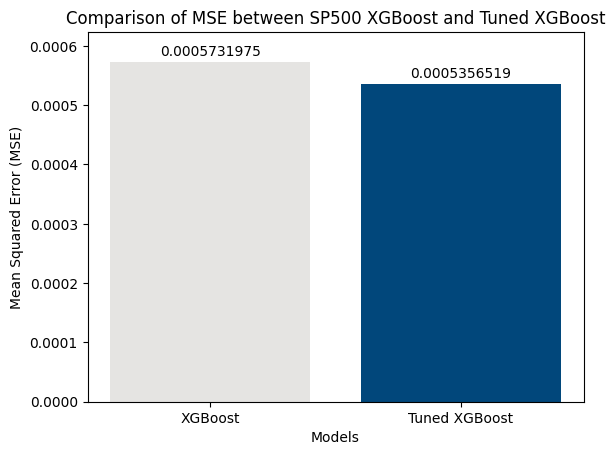

In [208]:
import matplotlib.pyplot as plt
# MSE values
mse_values = [mse_sp500, mse_sp500_tuned]

# Model names
model_names = ['XGBoost', 'Tuned XGBoost']

# Creating a bar plot
plt.bar(model_names, mse_values, color=['#E5E4E2', '#01477bff'], width=0.8)
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE between SP500 XGBoost and Tuned XGBoost')

# Adjusting the y-axis range
plt.ylim(0.00, max(mse_values) + 0.00005)

# Display the plot
plt.show()

In [70]:
#display the predicted price percentage change values with the actual price percentage change values
y_pred = sp500[1]
y_pred
y_test = sp500[3]
y_test_tuned = sp500_tuned[4]
y_pred_tuned = sp500_tuned[1]

In [69]:
# make a table of the predicted values and the actual values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_df
# combine the 2 dataframes

,Actual,Predicted
MSI Week 23,-0.023337,-0.002862
GLW Week 13,-0.014901,-0.004403
PARA Week 14,0.017842,0.022464
ZBH Week 10,-0.004357,-0.023180
HST Week 16,-0.003876,0.016639
...,...,...
COO Week 19,0.031889,0.043033
NCLH Week 49,-0.023537,0.001633
LYB Week 29,0.008410,0.014569
EG Week 38,-0.036571,-0.005451


In [88]:
# calculate r2 score
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.02890219385469317

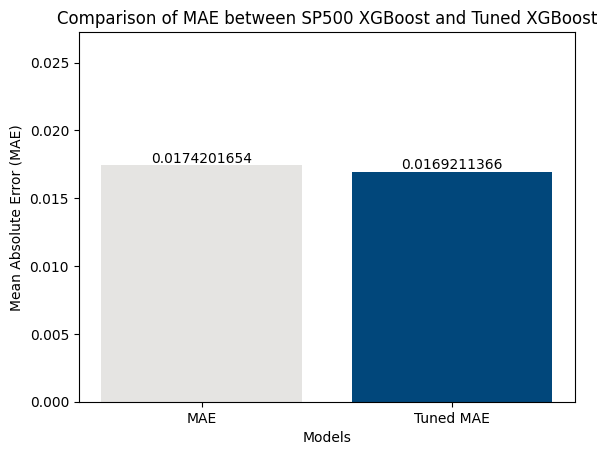

In [217]:
#plot the MAE and tuned MAE
# MAE values
mae_values = [mae, mae_tuned]
model_names = ['MAE', 'Tuned MAE']
plt.title('Comparison of MAE between SP500 XGBoost and Tuned XGBoost')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.bar(model_names, mae_values, color=['#E5E4E2', '#01477bff'])
for i, value in enumerate(mae_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')
plt.ylim(0.00, 0.025 + 0.0025)
plt.show()


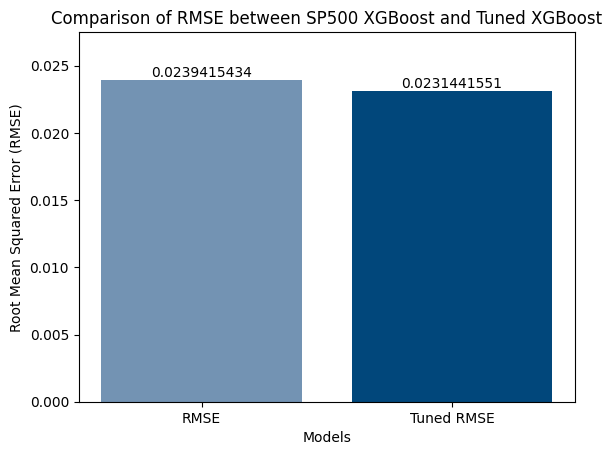

In [215]:
#plot the RMSE and tuned RMSE like the MAE
# RMSE values
rmse_values = [rmse, rmse_tuned]
model_names = ['RMSE', 'Tuned RMSE']
plt.title('Comparison of RMSE between SP500 XGBoost and Tuned XGBoost')
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.bar(model_names, rmse_values, color=['#7393B3', '#01477bff'])
for i, value in enumerate(rmse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')
plt.ylim(0.00, 0.025 + 0.0025)
plt.show()

In [121]:
#print the best parameters 
best_params = sp500_tuned[3]    
best_params

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 400}

# <b>Making Dataframes With our Clusters

In [51]:
# compare the list, symbols, to the stocks in the company column of the dataframe
# make a list of the ones in symbols that aren't in the column
# then remove those from the symbols list
remove = []
for i, symbol in enumerate(symbols):
    if symbol not in list(df_labels['Company']):
        remove.append(i)

remove
# make a list of the stocks that are at the indices in remove
remove_symbols = []
for i in remove:
    remove_symbols.append(symbols[i])
remove_symbols

['BF.B', 'CEG', 'GEHC', 'KVUE', 'VLTO']

In [52]:
cluster1

,Company,Cluster_Label
0,A,1
1,AAL,1
2,AAPL,1
4,ABNB,1
5,ABT,1
...,...,...
492,YUM,1
493,ZBH,1
494,ZBRA,1
495,ZION,1


In [53]:
cluster2

,Company,Cluster_Label
10,ADM,2
38,APA,2
59,BG,2
64,BKR,2
87,CF,2
106,COP,2
119,CTRA,2
123,CVX,2
144,DVN,2
158,EOG,2


In [54]:
cluster3

,Company,Cluster_Label
3,ABBV,3
13,AEE,3
14,AEP,3
30,AMGN,3
43,ATO,3
...,...,...
454,UNH,3
466,VRTX,3
469,VZ,3
475,WEC,3


In [55]:
sp500_pct_df

,Day 1,Day 2,Day 3,Day 4,Day 5
MMM Week 2,-0.014115,0.008850,0.002458,0.008918,-0.012595
MMM Week 4,0.000869,0.005498,-0.025611,0.005080,-0.041490
MMM Week 5,0.017903,0.008493,-0.004599,-0.013621,-0.022264
MMM Week 6,0.002738,0.007694,0.007573,-0.023833,-0.001252
MMM Week 7,-0.009590,-0.004240,-0.010868,-0.044914,-0.006862
...,...,...,...,...,...
ZTS Week 46,-0.014137,0.023011,-0.010279,-0.031562,0.014206
ZTS Week 48,-0.013125,-0.001890,0.042543,0.016219,0.004980
ZTS Week 49,-0.013277,-0.014678,-0.018295,0.022829,-0.001887
ZTS Week 50,-0.003455,0.013803,-0.020585,-0.020227,-0.028579


In [56]:
# run the model on each dataframe
y1 = cluster1_df['Day 5']
X1 = cluster1_df.drop(columns='Day 5')
cluster_1_model = train_xgboost_regressor(X1,y1)
cluster_1_mse = cluster_1_model[2]
print('Cluster 1 MSE: ' + str(round(cluster_1_mse, 8)))
cluster_1_model_tuned = xgboost_tuned(X1,y1)
cluster_1_mse_tuned = cluster_1_model_tuned[2]
print('Cluster 1 Tuned MSE: ' + str(round(cluster_1_mse_tuned, 8)))

Cluster 1 MSE: 0.000553
Cluster 1 Tuned MSE: 0.0005164


In [58]:
y2 = cluster2_df['Day 5']
X2 = cluster2_df.drop(columns='Day 5')
cluster_2_model = train_xgboost_regressor(X2,y2)
cluster_2_mse = cluster_2_model[2]
print('Cluster 2 MSE: ' + str(round(cluster_2_mse, 8)))
cluster_2_model_tuned = xgboost_tuned(X2,y2)
cluster_2_mse_tuned = cluster_2_model_tuned[2]
print('Cluster 2 Tuned MSE: ' + str(round(cluster_2_mse_tuned, 8)))

Cluster 2 MSE: 0.00069455
Cluster 2 Tuned MSE: 0.00054958


In [59]:
y3 = cluster3_df['Day 5']
X3 = cluster3_df.drop(columns='Day 5')
cluster_3_model = train_xgboost_regressor(X3,y3)
cluster_3_mse = cluster_3_model[2]
print('Cluster 3 MSE: ' + str(round(cluster_3_mse, 8)))
cluster_3_model_tuned = xgboost_tuned(X3,y3)
cluster_3_msetuned = cluster_3_model_tuned[2]
print('Cluster 3 Tuned MSE: ' + str(round(cluster_3_msetuned, 8)))

Cluster 3 MSE: 0.00028647
Cluster 3 Tuned MSE: 0.00025135


In [61]:
params1 = cluster_1_model_tuned[3]
params2 = cluster_2_model_tuned[3]
params3 = cluster_3_model_tuned[3]
print(params1)
print(params2)
print(params3)

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}
{'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 400}
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 400}


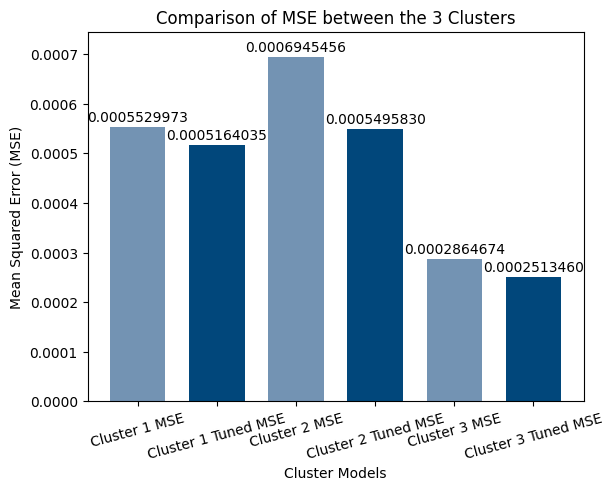

In [218]:
#plot the MSE value for each cluster and their corresponding tuned mse value next to it
# MSE values
mse_values = [cluster_1_mse, cluster_1_mse_tuned, cluster_2_mse, cluster_2_mse_tuned, cluster_3_mse, cluster_3_msetuned]
model_names = ['Cluster 1 MSE', 'Cluster 1 Tuned MSE', 'Cluster 2 MSE', 'Cluster 2 Tuned MSE', 'Cluster 3 MSE', 'Cluster 3 Tuned MSE']
plt.title('Comparison of MSE between the 3 Clusters')
plt.xlabel('Cluster Models')
plt.ylabel('Mean Squared Error (MSE)')
#make the color a gradient of blues
plt.bar(model_names, mse_values, color= ['#7393B3', '#01477bff', '#7393B3', '#01477bff', '#7393B3', '#01477bff'], width=0.7)
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')
plt.ylim(0.00, max(mse_values) + 0.00005)
plt.xticks(rotation=15)
plt.show()

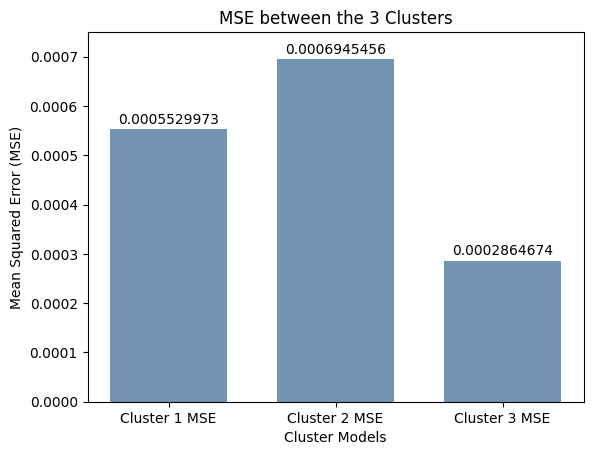

In [222]:
#plot the MSE value for each cluster and their corresponding tuned mse value next to it
# MSE values
mse_values = [cluster_1_mse, cluster_2_mse, cluster_3_mse]
model_names = ['Cluster 1 MSE',  'Cluster 2 MSE', 'Cluster 3 MSE']
plt.title('MSE between the 3 Clusters')
plt.xlabel('Cluster Models')
plt.ylabel('Mean Squared Error (MSE)')
#make the color a gradient of blues
plt.bar(model_names, mse_values, color= ['#7393B3','#7393B3','#7393B3'], width=0.7)
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')
plt.ylim(0.00, 0.0007 + 0.00005)
plt.show()

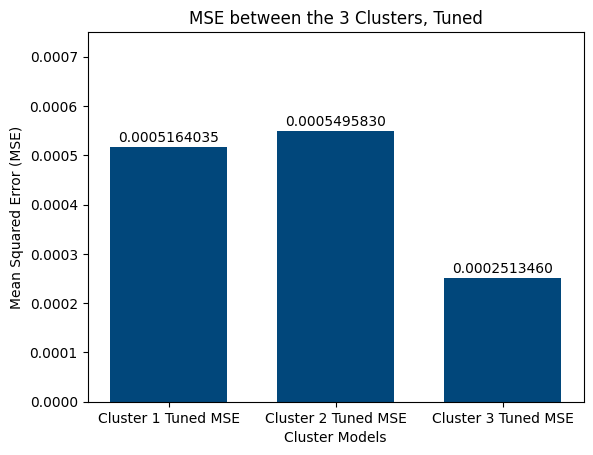

In [221]:
#plot the MSE value for each cluster tuned mse value next to it
# MSE values
mse_values = [cluster_1_mse_tuned,cluster_2_mse_tuned, cluster_3_msetuned]
model_names = ['Cluster 1 Tuned MSE', 'Cluster 2 Tuned MSE', 'Cluster 3 Tuned MSE']
plt.title('MSE between the 3 Clusters, Tuned')
plt.xlabel('Cluster Models')
plt.ylabel('Mean Squared Error (MSE)')
#make the color a gradient of blues
plt.bar(model_names, mse_values, color= ['#01477bff','#01477bff','#01477bff'], width=0.7)
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')
plt.ylim(0.00, 0.0007 + 0.00005)
plt.show()

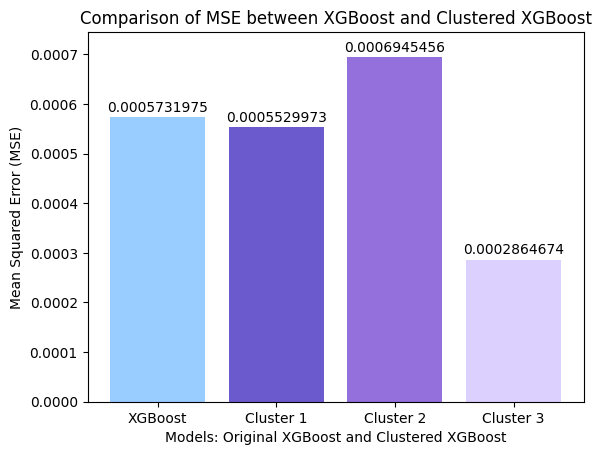

In [178]:
# plot the mse values for each cluster compared to the original sp500 model mse
# MSE values
mse_values = [mse_sp500, cluster_1_mse, cluster_2_mse, cluster_3_mse]
# plot the mse values for each cluster compared to the original sp500 model mse

# Model names
model_names = ['XGBoost', 'Cluster 1', 'Cluster 2', 'Cluster 3']

# Creating a bar plot
plt.bar(model_names, mse_values, color=['#99CCFF', '#6A5ACD', '#9370DB', '#DCD0FF',])
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')

plt.xlabel('Models: Original XGBoost and Clustered XGBoost')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE between XGBoost and Clustered XGBoost')

# Adjusting the y-axis range
plt.ylim(0.00, max(mse_values) + 0.00005)


# Display the plot
plt.show()


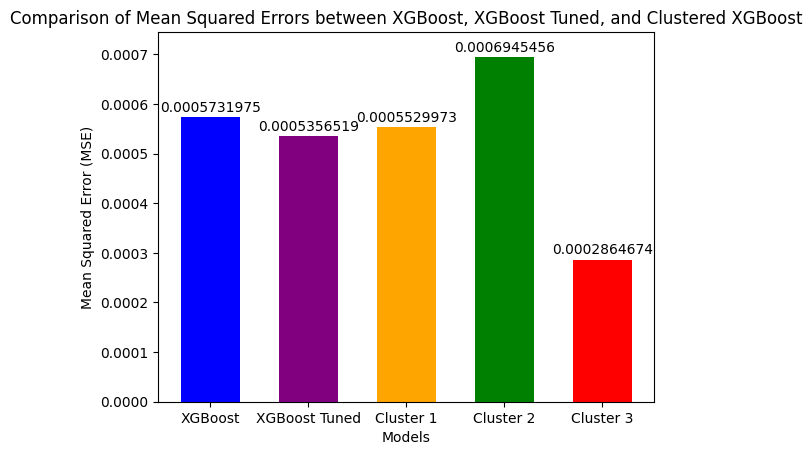

In [157]:
# plot the mse values for each cluster compared to the original sp500 model mse
# MSE values
mse_values = [mse_sp500,mse_sp500_tuned, cluster_1_mse, cluster_2_mse, cluster_3_mse]
# plot the mse values for each cluster compared to the original sp500 model mse

# Model names
model_names = ['XGBoost','XGBoost Tuned', 'Cluster 1', 'Cluster 2', 'Cluster 3']

# Creating a bar plot
plt.bar(model_names, mse_values, color=['blue', 'purple', 'orange', 'green', 'red',], width=0.6)
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')

plt.xlabel('Models: Original XGBoost and Clustered XGBoost')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Errors between XGBoost, XGBoost Tuned, and Clustered XGBoost')

# Adjusting the y-axis range
plt.ylim(0.00, max(mse_values) + 0.00005)

# Display the plot
plt.show()

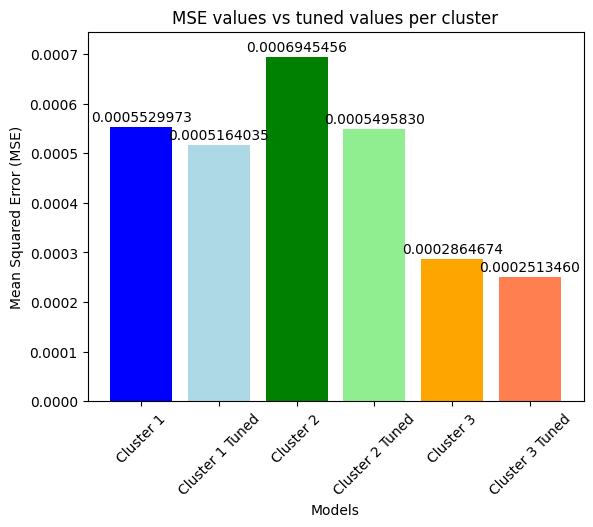

In [64]:
#plot the mse values for each cluster next to the mse tuned values for each cluster
mse_values = [cluster_1_mse, cluster_1_mse_tuned, cluster_2_mse, cluster_2_mse_tuned, cluster_3_mse, cluster_3_msetuned]
model_names= ['Cluster 1', 'Cluster 1 Tuned', 'Cluster 2', 'Cluster 2 Tuned', 'Cluster 3', 'Cluster 3 Tuned']

plt.bar(model_names, mse_values, color=['blue', 'lightblue', 'green', 'lightgreen', 'orange', 'coral'])
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values vs tuned values per cluster')

# Adjusting the y-axis range
plt.ylim(0.00, max(mse_values) + 0.00005)

plt.xticks(rotation=45)
# Display the plot
plt.show()

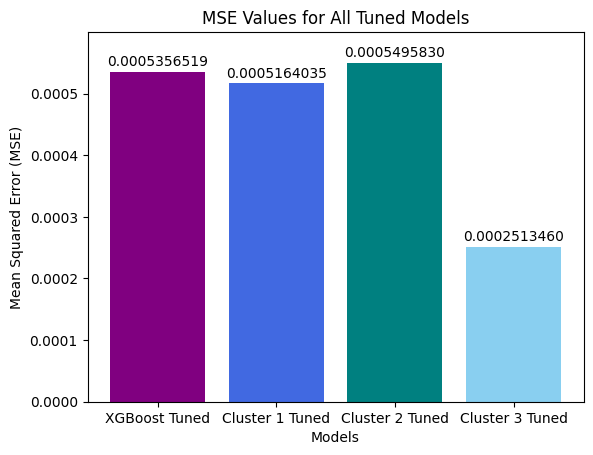

In [179]:
#plot all the tuned model mse values
# MSE values
mse_values = [mse_sp500_tuned, cluster_1_mse_tuned, cluster_2_mse_tuned, cluster_3_msetuned]
model_names = ['XGBoost Tuned', 'Cluster 1 Tuned', 'Cluster 2 Tuned', 'Cluster 3 Tuned']

plt.bar(model_names, mse_values, color=['purple', '#4169E1', '#008080', '#89CFF0',])
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Values for All Tuned Models')

# Adjusting the y-axis range
plt.ylim(0.00, max(mse_values) + 0.00005)

# Display the plot
plt.show()

In [66]:
#average the mse values for each cluster
cluster_average = (cluster_1_mse + cluster_2_mse + cluster_3_mse)/3
print('Average MSE for Clustered XGBoost: ' + str(round(cluster_average, 8)))
cluster_average_tuned = (cluster_1_mse_tuned + cluster_2_mse_tuned + cluster_3_msetuned)/3
print('Average Tuned MSE for Clustered XGBoost: ' + str(round(cluster_average_tuned, 8)))

Average MSE for Clustered XGBoost: 0.00051134
Average Tuned MSE for Clustered XGBoost: 0.00043911


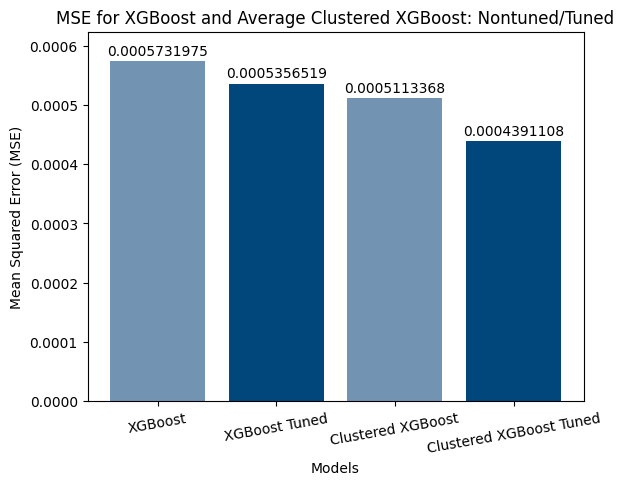

In [225]:
#plot all the tuned model mse values
# MSE values
mse_values = [mse_sp500, mse_sp500_tuned,cluster_average, cluster_average_tuned]
model_names = ['XGBoost', 'XGBoost Tuned','Clustered XGBoost', 'Clustered XGBoost Tuned']
plt.bar(model_names, mse_values, color=['#7393B3', '#01477bff', '#7393B3','#01477bff',])
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for XGBoost and Average Clustered XGBoost: Nontuned/Tuned')

# Adjusting the y-axis range
plt.ylim(0.00, max(mse_values) + 0.00005)
#rotate the x axis
plt.xticks(rotation=10)
# Display the plot
plt.show()

In [233]:
# make a dataframe of how many companies are in each cluster
cluster_counts = pd.DataFrame(df_labels['Cluster_Label'].value_counts())
#keep it in 1,2,3 order
cluster_counts = cluster_counts.sort_index()
#cluster_counts = cluster_counts.T
#make the column say "company count"
cluster_counts.columns = ['Company Count']
cluster_counts.T

Cluster_Label,1,2,3
Company Count,391,27,79


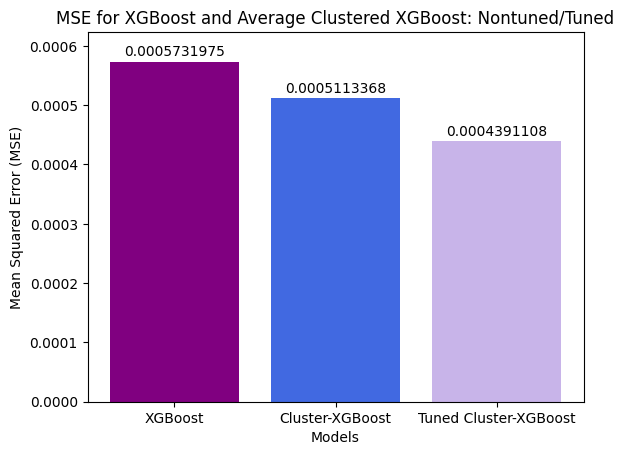

In [198]:
#plot all the tuned model mse values
# MSE values
mse_values = [mse_sp500, cluster_average, cluster_average_tuned]
model_names = ['XGBoost', 'Cluster-XGBoost', 'Tuned Cluster-XGBoost']
plt.bar(model_names, mse_values, color=['purple', '#4169E1', '#C8B4E9'])
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for XGBoost and Average Clustered XGBoost: Nontuned/Tuned')

# Adjusting the y-axis range
plt.ylim(0.00, max(mse_values) + 0.00005)
#rotate the x axis
# Display the plot
plt.show()

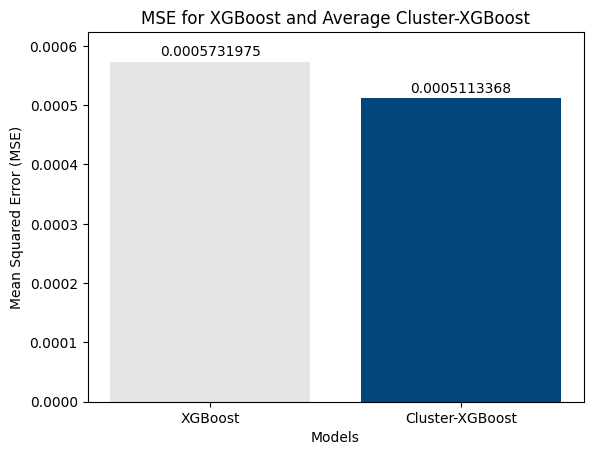

In [234]:
#plot all the tuned model mse values
# MSE values
mse_values = [mse_sp500, cluster_average]
model_names = ['XGBoost', 'Cluster-XGBoost']
plt.bar(model_names, mse_values, color=['#E5E4E2', '#01477bff',])
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for XGBoost and Average Cluster-XGBoost')

# Adjusting the y-axis range
plt.ylim(0.00, max(mse_values) + 0.00005)
#rotate the x axis
# Display the plot
plt.show()